# Example clustering

This notebook will show some of `clustering` algorithms used in the `siamese_networks` project. These algorithms arereally useful to identify clusters in the prediction of a `Siamese Network` (cf https://github.com/yui-mhcp/siamese_networks)

I have implemented 2 main algorithms : 
- `KMeans` : the classical KMeans algorithm implemented in `tensorflow`. It also supports a variant which tries to discover the best value of `k` by trying multiple values of `k` and finding an *elbow* in the scores. i.e. a `k` where the SSE score decreases but less than before. 
- `KPropagation` : a funny algorithm I implemented to use the `similarity_matrix` produced by the `siamese_networks`. The idea is to assign a label to the 1st point and propagate the label to other points that are close enough from the cluster. If the point is too far from the cluster (mean similarity less than a threshold), it will be assigned to a new cluster.

Note that the `KPropagation` needs a `similarity_matrix` but if no matrix is given, it will create based on the formula : $ 1. - normalized\_distance\_matrix $ where *normalized_distance_matrix* is the distance matrix between each point divided by the maximum distance. 

Note that both implementation have a mechanism to remove *mini clusters* from less than N elements and reassign them to the nearest cluster (because both can decide to create a new cluster for 2 points just to have a better score even if it is not relevant). You can adjust this behaviour by modifying the `min_cluster_size` parameter. It is the reason why the number of clusters can be less than `k` (in ``KMeans) !

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from kneed import KneeLocator
from sklearn.datasets import make_blobs, make_moons

from utils import plot, plot_embedding, sample_df
from utils.embeddings import load_embedding, embeddings_to_np
from utils.distance import KMeans, KPropagation

random_state = 10
directory = 'example_data'
filename = 'embeddings_{}_voxforge.csv'

## Test on blobs

Blobs are vectors grouped around a same center, quite perfect to test the variable `KMeans` and the `KPropagation` algorithms to see if they correcly detect well separable clusters.

The `KMeans` algorithm is highly influenced by its initialization, it is the reason why I implemented (like in `sklearn`) multiple initialization and keep the best one. Even with this behaviour, it suffers from a high variance especially when the feature size is high.

A contrario, the `KPropagation` tends to be better when the dimension are large enough (greater than 10) (at least when no similarity matrixis given). 

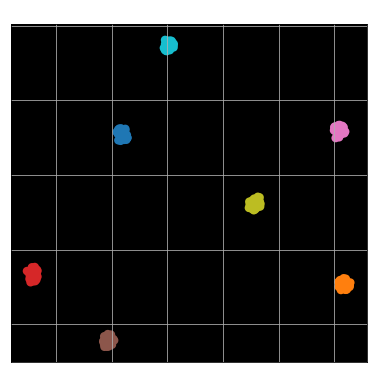

In [2]:
blobs_x, blobs_y = make_blobs(
    n_samples = 250, n_features = 128, centers = 7, cluster_std = 1., random_state = random_state
)
plot_embedding(blobs_x, blobs_y)

Best k = 7
# clusters : 5
Accuracy (mean : 71.03) : [1.0, 1.0, 0.9722222222222222, 1.0, 0.0, 1.0, 0.0]


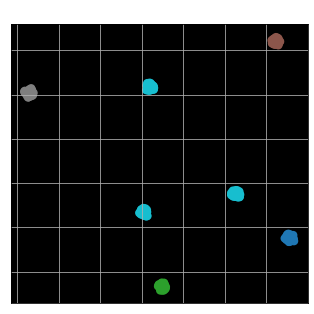

In [6]:
kmeans = KMeans(blobs_x, k = -1, max_k = 10, debug = True)
acc, accs = kmeans.evaluate(blobs_y)

print("Best k = {}".format(kmeans.k))
print("# clusters : {}".format(kmeans.n_cluster))
print("Accuracy (mean : {:.2f}) : {}".format(acc * 100, accs))

kmeans.plot()

# clusters : 7
Accuracy (mean : 100.00) : [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


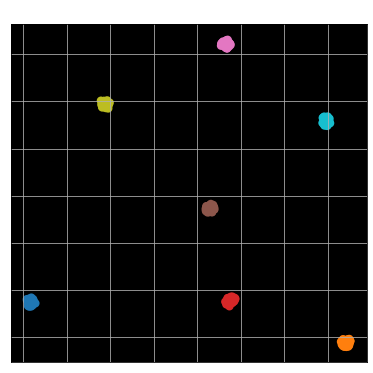

In [5]:
k_prop = KPropagation(
    blobs_x, min_cluster_size = 0.1, threshold = 0.6, distance_metric = 'euclidian', debug = False
)
acc, accs = k_prop.evaluate(blobs_y)

print("# clusters : {}".format(k_prop.n_cluster))
print("Accuracy (mean : {:.2f}) : {}".format(acc * 100, accs))

k_prop.plot()

## Test with embeddings

This test is the same as before but with real `embeddings` produced by the `siamese_networks` on the `VoxForge` dataset

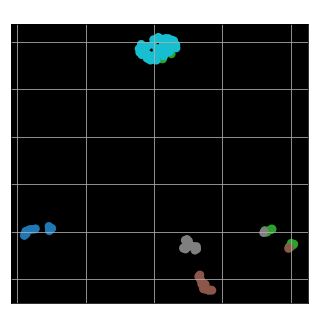

In [6]:
embeddings = load_embedding(directory, embedding_dim = 256, embedding_name = filename)

samples = sample_df(embeddings, n = 5, n_sample = 50)

x, y = embeddings_to_np(samples), samples['id'].values

plot_embedding(x, y)

Best k = 9
# clusters : 4
Accuracy (mean : 68.00) : [0.6, 1.0, 0.9, 0.0, 0.9]


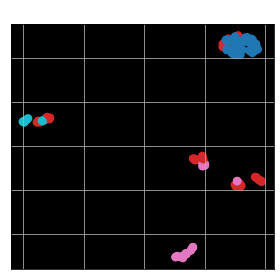

In [7]:
kmeans = KMeans(x, k = -1, min_k = 3, max_k = 10)
acc, accs = kmeans.evaluate(y)

print("Best k = {}".format(kmeans.k))
print("# clusters : {}".format(kmeans.n_cluster))
print("Accuracy (mean : {:.2f}) : {}".format(acc * 100, accs))

kmeans.plot()

# clusters : 5
Accuracy (mean : 42.80) : [1.0, 0.4, 0.3, 0.1, 0.34]


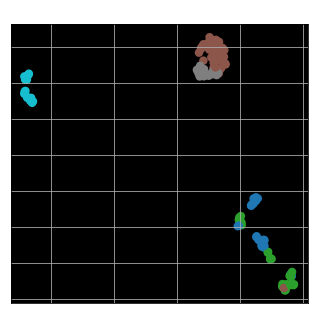

In [8]:
k_prop = KPropagation(
    x, k = 5, min_cluster_size = 0.1, threshold = 0.7, min_threshold = 0.5,
    distance_metric = 'euclidian', debug = False
)
acc, accs = k_prop.evaluate(y)

print("# clusters : {}".format(k_prop.n_cluster))
print("Accuracy (mean : {:.2f}) : {}".format(acc * 100, accs))

k_prop.plot()

## Tests on moons

This test is harder because data are in 2-D (which is quite bad for the `KPropagation` as no similarity matrix is given) and the shape is quite strange. 

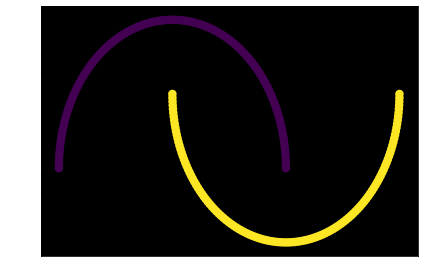

In [40]:
moons_x, moons_y = make_moons(
    n_samples = 250, random_state = random_state
)

plot(moons_x[:,0], moons_x[:,1], c = moons_y, plot_type = 'scatter')

Best k = 4
# clusters : 4
Accuracy (mean : 53.20) : [0.528, 0.536]


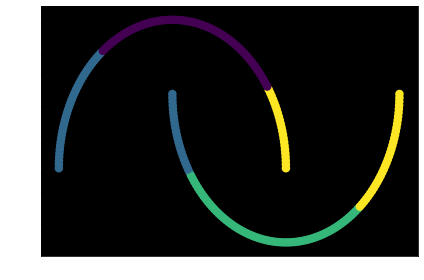

In [41]:
kmeans = KMeans(moons_x, k = -1, max_k = 10, debug = True)
acc, accs = kmeans.evaluate(moons_y)

print("Best k = {}".format(kmeans.k))
print("# clusters : {}".format(kmeans.n_cluster))
print("Accuracy (mean : {:.2f}) : {}".format(acc * 100, accs))

plot(moons_x[:,0], moons_x[:,1], c = kmeans.labels, plot_type = 'scatter')

# clusters : 4
Accuracy (mean : 61.60) : [0.624, 0.608]


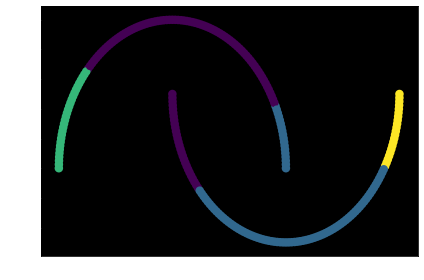

In [43]:
k_prop = KPropagation(
    moons_x, k = 5, threshold = 0.7, use_mean = False, min_threshold = 0.4,
    distance_metric = 'euclidian', debug = False
)
acc, accs = k_prop.evaluate(moons_y)

print("# clusters : {}".format(k_prop.n_cluster))
print("Accuracy (mean : {:.2f}) : {}".format(acc * 100, accs))

plot(moons_x[:,0], moons_x[:,1], c = k_prop.labels, plot_type = 'scatter')